<a href="https://colab.research.google.com/github/Orangefox76200/CapsNet-LSTM/blob/main/CapsNet_LSTM_Nikkei225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Time Series Forecasting Using A Hybrid CapsNet-LSTM Architecture: Using real world data (Nikkei225 Index)

Nikkei225 Index dataset contains data of the Nikkei225 DJIA Index prices recorded from Jan 1st, 2010 to Dec 31st, 2019. In addition to be using Tensorflow's layers for processing sequence data such as LSTMs we will also intergrate Capsule Network in our proposed hybrid architecture to improve the model's performance.

Let's get started!

In [1]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 49.0 MB/s 


In [2]:
import keras.backend as K
import tensorflow as tf

import keras
import keras_tuner
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [3]:
# Set seed
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [4]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
print(tf.__version__)

2.8.2


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [7]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [8]:
N225_raw = pd.read_csv('/content/gdrive/MyDrive/Nikkei225/N225.csv')
N225_raw

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/1/2010,10609.33984,10694.49023,10608.13965,10654.79004,10654.79004,104400000
1,5/1/2010,10719.44043,10791.04004,10655.57031,10681.83008,10681.83008,166200000
2,6/1/2010,10709.54981,10768.61035,10661.16992,10731.45020,10731.45020,181800000
3,7/1/2010,10742.75000,10774.00000,10636.66992,10681.66016,10681.66016,182600000
4,8/1/2010,10743.29981,10816.45020,10677.55957,10798.32031,10798.32031,211800000
...,...,...,...,...,...,...,...
2443,24/12/2019,23839.17969,23853.56055,23796.34961,23830.58008,23830.58008,37900000
2444,25/12/2019,23813.58984,23824.84961,23782.86914,23782.86914,23782.86914,31600000
2445,26/12/2019,23787.69922,23931.50977,23775.40039,23924.91992,23924.91992,40300000
2446,27/12/2019,23953.75000,23967.17969,23837.72070,23837.72070,23837.72070,44800000


In [9]:
series = N225_raw.iloc[:,4]

In [10]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

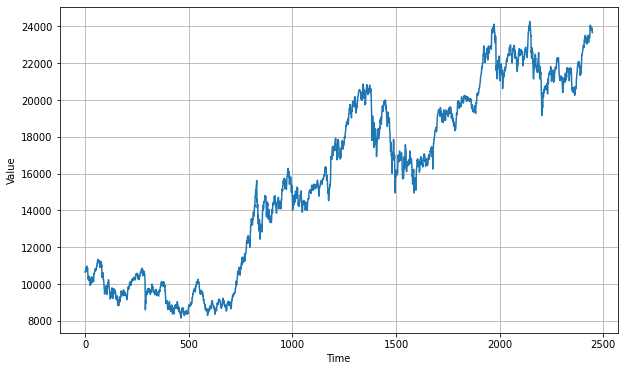

In [12]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int((len(series)-150)*0.8)
    WINDOW_SIZE = 250
    BATCH_SIZE = 32

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

The `train_val_split` and `windowed_dataset` functions:

In [13]:
def train_val_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:-150]
    series_valid = series[time_step:-150]
    time_test = time[-150:]
    series_test = series[-150:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

# Split the dataset
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_test_split(G.TIME, G.SERIES)

min-max normalization:

In [14]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [15]:
series_norm = min_max_normalization(G.SERIES)

In [16]:
series_train_norm = series_norm[:G.SPLIT_TIME]
series_valid_norm = series_norm[G.SPLIT_TIME:-150]
series_test_norm = series_norm[-150:]

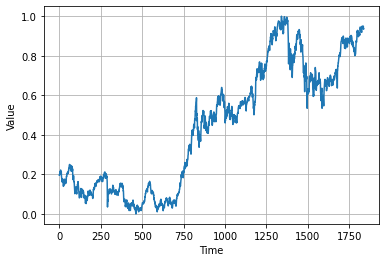

In [17]:
plot_series(time_train, series_train_norm)

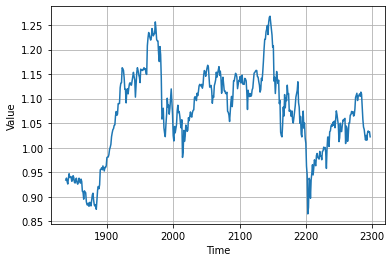

In [18]:
plot_series(time_valid, series_valid_norm)

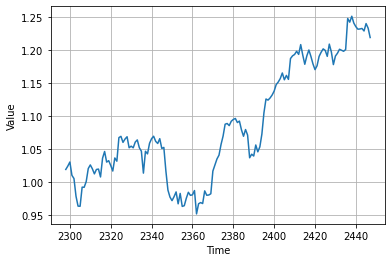

In [19]:
plot_series(time_test, series_test_norm)

In [20]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds
train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
val_set = windowed_dataset(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
train_val_set = windowed_dataset(series_norm[0:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

## Compiling the model


### Defining the model architecture (CapsNet-LSTM)


In [21]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [22]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

@tf.keras.utils.register_keras_serializable() 
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

In [23]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [26]:
input_shape = (G.WINDOW_SIZE, 1)

In [27]:
# Prepare callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

In [28]:
K.clear_session()

### Tune hyper-parameters

In [29]:
def build_CapsNet_LSTM(hp):
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=hp.Int('Conv1_units', 256, 1024, 256), kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
    conv1d_2 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='causal',name = 'conv1d_2')(conv1d_1)

    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 64, 8))(conv1d_2)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = hp.Int('dim_capsule', 256, 1024, 256), routings = hp.Int('routings', 3, 5, 1)))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(hp.Int('lstm_units', 150, 300, 50))(digit_caps)

    # Dropout  
    dropout = tf.keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, 0.1))(lstm)

    # Dense layer
    dense1 = tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu")(dropout)
    dense2 = tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu")(dense1)
    output = tf.keras.layers.Dense(1)(dense2)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_CapsNet_LSTM(keras_tuner.HyperParameters())

tuner_capsnet_lstm = keras_tuner.Hyperband(
    hypermodel=build_CapsNet_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name='capsnet_lstm_N225',
    overwrite = False)

tuner_capsnet_lstm.search(train_set, epochs=50, validation_data=val_set, callbacks=[stop_early])

tuner_capsnet_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_capsnet_lstm = tuner_capsnet_lstm.get_best_hyperparameters(5)

Trial 2 Complete [00h 00m 41s]
val_mae: 0.2517385482788086

Best val_mae So Far: 0.09093088656663895
Total elapsed time: 00h 01m 29s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
768               |256               |Conv1_units
512               |1024              |dim_capsule
4                 |3                 |routings
300               |200               |lstm_units
0.2               |0.3               |dropout
50                |40                |dense1_units
20                |10                |dense2_units
0.0026588         |0.00028406        |lr
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
     14/Unknown - 11s 170ms/step - loss: 0.0026 - mae: 0.0507

In [ ]:
# Build the model with the best hp.
with strategy.scope():
  capsnet_lstm = build_CapsNet_LSTM(best_hps_capsnet_lstm[0])
# Fit with the entire dataset.
capsnet_lstm.fit(train_val_set, epochs=200)

In [ ]:
print(capsnet_lstm.summary())

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [ ]:
# Compute the forecast for all the series
capsnet_lstm_forecast = model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_capsnet_lstm = capsnet_lstm_forecast[-150:]

# Reverse normalization
series_test_hat_capsnet_lstm = reverse_normalization(series_test_hat_capsnet_lstm)

In [ ]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value (Nikkei225)", "Predicted Value (Nikkei225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Forecasting_results/capsnet_lstm_forecasts_N225.svg")

In [ ]:
rmse_capsnet_lstm, mae_capsnet_lstm, mape_capsnet_lstm= compute_metrics(series_test, series_test_hat_capsnet_lstm)

print(f"mse: {rmse_capsnet_lstm:.2f}, mae: {mae_capsnet_lstm:.2f} , mape: {mape_capsnet_lstm:.2f} for forecast")

In [ ]:
# Save model

capsnet_lstm.save('/content/gdrive/MyDrive/Saved_models/capsnet_lstm_N225.h5')

In [ ]:
capsnet_lstm.save_weights('/content/gdrive/MyDrive/Saved_models/capsnet_lstm_N225_weights.h5', overwrite=True, save_format=None, options=None)

### Load the saved model
Direct loading the saved model encounters issues. On this occasion, we first rebuild the proposed model using the optimal hyper-parameters, then load the saved weights to this model.

In [ ]:
saved_capsnet_lstm = load_model('/content/gdrive/MyDrive/Saved_models/capsnet_lstm_N225.h5')

In [ ]:
print(saved_capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 256)          768       
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 512)          262656    
                                                                 
 reshape_1 (Reshape)         (None, 250, 64, 8)        0         
                                                                 
 lambda_1 (Lambda)           (None, 250, 64, 8)        0         
                                                                 
 time_distributed_1 (TimeDis  (None, 250, 768)         393216    
 tributed)                                                       
                                                      

In [ ]:
# Compute the forecast for all the series
saved_capsnet_lstm_forecast = model_forecast(saved_capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_saved_capsnet_lstm = saved_capsnet_lstm_forecast[-150:]
series_test_hat_saved_capsnet_lstm = reverse_normalization(series_test_hat_saved_capsnet_lstm)

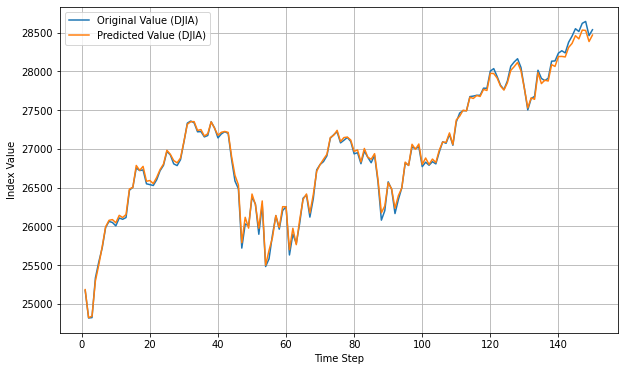

In [ ]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_saved_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "Predicted Value (DJIA)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Forecasting_results/saved_capsnet_lstm_forecasts.svg")

In [ ]:
rmse_saved_capsnet_lstm, mae_saved_capsnet_lstm, mape_saved_capsnet_lstm= compute_metrics(series_test, series_test_hat_saved_capsnet_lstm)

print(f"mse: {rmse_saved_capsnet_lstm:.2f}, mae: {mae_saved_capsnet_lstm:.2f} , mape: {mape_saved_capsnet_lstm:.2f} for forecast")

mse: 40.34, mae: 31.51 , mape: 0.12 for forecast


## Baseline (LSTM, CNN-LSTM)

### LSTM

In [ ]:
def build_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50), input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_LSTM(keras_tuner.HyperParameters())

tuner_lstm = keras_tuner.Hyperband(
    hypermodel=build_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name="lstm_N225",
    overwrite=False)

tuner_lstm.search(train_set, epochs=50, validation_data=val_set,callbacks=[stop_early])

tuner_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_lstm = tuner_lstm.get_best_hyperparameters(5)



In [ ]:
# Build the model with the best hp.
with strategy.scope():
  lstm = build_LSTM(best_hps_lstm[0])
# Fit with the entire dataset.
lstm.fit(train_val_set, epochs=200)

In [ ]:
print(lstm.summary())

In [ ]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_lstm = lstm_forecast[-150:]
series_test_hat_lstm = reverse_normalization(series_test_hat_lstm)

In [ ]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value (Nikkei225)", "Predicted Value (Nikkei225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Forecasting_results/lstm_forecasts_N225.svg")

In [ ]:
rmse_lstm, mae_lstm, mape_lstm= compute_metrics(series_test, series_test_hat_lstm)

print(f"mse: {rmse_lstm:.2f}, mae: {mae_lstm:.2f} , mape: {mape_lstm:.2f} for forecast")

In [ ]:
# Save model
lstm.save("/content/gdrive/MyDrive/Saved_models/lstm_N225.h5")

### CNN-LSTM

In [ ]:
def build_CNN_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=hp.Int('Conv_units', 256, 1024, 256), kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50)),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, step = 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, step = 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_CNN_LSTM(keras_tuner.HyperParameters())

tuner_cnn_lstm = keras_tuner.Hyperband(
    hypermodel=build_CNN_LSTM,
    objective="val_mae",
    max_epochs=50,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    seed = 1,
    directory='/content/gdrive/MyDrive/Tuner',
    project_name="cnn_lstm_N225",
    overwrite=False)


tuner_cnn_lstm.search(train_set, epochs=50, validation_data=val_set, callbacks=[stop_early])

tuner_cnn_lstm.results_summary()

# Get the top 5 hyperparameters.
best_hps_cnn_lstm = tuner_cnn_lstm.get_best_hyperparameters(5)

In [ ]:
# Build the model with the best hp.
with strategy.scope():
  cnn_lstm = build_CNN_LSTM(best_hps_cnn_lstm[0])
# Fit with the entire dataset.
cnn_lstm.fit(train_val_set, epochs=200)

In [ ]:
print(cnn_lstm.summary())

In [ ]:
# Compute the forecast for all the series
cnn_lstm_forecast = model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_cnn_lstm = cnn_lstm_forecast[-150:]
series_test_hat_cnn_lstm = reverse_normalization(series_test_hat_cnn_lstm)

In [ ]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value (Nikkei225)", "Predicted Value (Nikkei225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Forecasting_results/cnn_lstm_forecasts_N225.svg")

In [ ]:
rmse_cnn_lstm, mae_cnn_lstm, mape_cnn_lstm= compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"mse: {rmse_cnn_lstm:.2f}, mae: {mae_cnn_lstm:.2f} , mape: {mape_cnn_lstm:.2f} for forecast")

In [ ]:
# Save model
cnn_lstm.save('/content/gdrive/MyDrive/Saved_models/cnn_lstm_N225.h5')

## Camparison

Compare our proposed Capsnet-LSTM with LSTM and CNN-LSTM

### Three forecasting results in one figure:

In [ ]:
plt.figure(figsize=(30, 20))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value", "Predicted Value (CapsNet-LSTM)","Predicted Value (LSTM)","Predicted Value (CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Forecasting_results/all_together_forecasts_N225.svg")

### Compare the rmse, mae mape

In [ ]:
# Print RMSE

print(rmse_capsnet_lstm)
print(rmse_lstm)
print(rmse_cnn_lstm)

In [ ]:
# Print MAE

print(mae_capsnet_lstm)
print(mae_lstm)
print(mae_cnn_lstm)

In [ ]:
# Print MAPE

print(mape_capsnet_lstm)
print(mape_lstm)
print(mape_cnn_lstm)